In [99]:
# pip install SimpleITK
# pip install nibabel

In [100]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [101]:
%run utils.ipynb

# Visualizing one image

In [102]:
image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM
# image = sitk.ReadImage("../data/picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory EMILIA

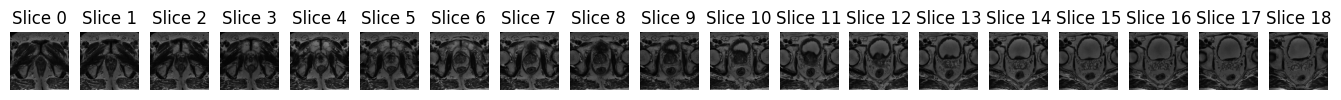

In [103]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

# Merging images with label in one dictionary

In [104]:
directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
# directory = "../data/picai_public_images_fold1" // EMILIA

In [105]:
##### ADD A KEY FOR AGE 
dict_images = {}

for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if "t2w" in file_name and file_name.endswith('.mha'):
                full_path = os.path.join(directory, folder, file_name)
                if os.path.exists(full_path):
                    short_name = '_'.join(file_name.split('_')[:2])
                    image = sitk.ReadImage(full_path)
                    dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'patient_id': None}

In [106]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683a8c540> >,
 'case_pca': None,
 'patient_age': None,
 'patient_id': None}

In [107]:
#size of the dictionary
len(dict_images)

298

We stored 3 things: 
* the nii files that have the color coded images 
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

# Opening nii files

In [108]:
# path = '../10035_1000035.nii'


In [109]:
# img = nib.load(path).get_fdata()
# img.shape

In [110]:
# print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


In [111]:
# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(img[:,:,1 + i])
# plt.show()

# Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [112]:
labels_path = "../marksheet.csv"
# labels_path = "../data/marksheet.csv"

In [113]:
df = pd.read_csv(labels_path)

In [114]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [115]:
df['case_csPCa'].value_counts()

NO     1075
YES     425
Name: case_csPCa, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [116]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [117]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [118]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

## Adding to a dictionary based on their full name

In [119]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Found 10008_1000008
Could not find 10009_1000009
Found 10010_1000010
Found 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Found 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Found 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Found 10024_1000024
Could not find 10025_1000025
Found 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Found 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find 10034_1000034
Could not find 10035_1000035
Found 10036_1000036
Could no

In [120]:
found, not_found

(298, 1202)

In [121]:
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683bd7f90> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x68b6f7240> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x68b6f6f10> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683a7b090> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683a7a130> >,
  'case_pca': 0,
  'patient_age': 52,
  'patient_id': '11371_1001394'},


### Evaluating class imbalance in final sample

In [122]:
# Extract 'case_pca' values from dictionary values
case_pca_values = [item['case_pca'] for item in dict_images.values()]

# Count occurrences of 'YES' and 'NO'
counts = Counter(case_pca_values)
yes_count = counts[1]
no_count = counts[0]

print(f"Count of 'YES': {yes_count}")
print(f"Count of 'NO': {no_count}")

Count of 'YES': 77
Count of 'NO': 221


In [123]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683bd7f90> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x68b6f7240> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x68b6f6f10> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683a7b090> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683a7a130> >,
  'case_pca': 0,
  'patient_age': 52,
  'patient_id': '11371_1001394'},


In [124]:
dict_images['10010_1000010']

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x683a8c540> >,
 'case_pca': 0,
 'patient_age': 67,
 'patient_id': '10010_1000010'}

# Image Preprocessing

In [125]:
## Images for resnet model alone 
# images = [forresnet(entry['image']) for entry in dict_images.values()]

In [126]:
import torch
import torch.nn.functional as F
from torchvision import transforms

def preprocess_image(image_sample):
    """
    Preprocess the image for ResNet-50 model
    """
    # Assuming images[0] is a SimpleITK image
    image_sitk = image_sample

    # Convert SimpleITK image to numpy array
    image_array = sitk.GetArrayFromImage(image_sitk)
    middle_slice_index = math.floor(image_array.shape[0] / 2)
    image_array = image_array[middle_slice_index, :, :]
    print("Original shape:", image_array.shape)  # (23, 384)

    # Add extra dimension to make it a 3D tensor
    image_array = np.expand_dims(image_array, axis=0)

    # Convert to float32
    image_array = image_array.astype(np.float32)

    # Convert to tensor and add batch dimension
    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0)

    # Resize the image to (224, 224)
    image_tensor = F.interpolate(image_tensor, size=(224, 224))

    # Normalize the image
    normalize = transforms.Normalize(mean=[0.485], std=[0.229])
    image_tensor = normalize(image_tensor)

    image_tensor = image_tensor.squeeze(0)

    if image_tensor.shape[1] == 1:
        image_tensor = torch.cat([image_tensor] * 3, dim=1)

    print("Shape after normalization:", image_tensor.shape)


    return image_tensor


In [127]:
def preprocess_image(image_sample):
    """
    Preprocess the image for ResNet-50 model
    """
    # Assuming image_sample is a SimpleITK image
    image_sitk = image_sample

    # Convert SimpleITK image to numpy array
    image_array = sitk.GetArrayFromImage(image_sitk)
    middle_slice_index = math.floor(image_array.shape[0] / 2)
    image_array = image_array[middle_slice_index, :, :]
    print("Original shape:", image_array.shape)  # (23, 384)

    # Convert to float32
    image_array = image_array.astype(np.float32)

    # Normalize the image
    image_array /= 255.0

    # Calculate aspect ratio
    aspect_ratio = image_array.shape[1] / image_array.shape[0]

    # Crop the image to a square aspect ratio
    if aspect_ratio > 1:
        crop_size = int(image_array.shape[0] / aspect_ratio)
        crop_start = (image_array.shape[1] - crop_size) // 2
        image_array = image_array[:, crop_start:crop_start+crop_size]
    elif aspect_ratio < 1:
        crop_size = int(image_array.shape[1] * aspect_ratio)
        crop_start = (image_array.shape[0] - crop_size) // 2
        image_array = image_array[crop_start:crop_start+crop_size, :]

    # Convert to tensor and add batch dimension
    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0)

    # Resize the image to (224, 224)
    image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(224, 224))

    # Normalize the image
    normalize = transforms.Normalize(mean=[0.485], std=[0.229])
    image_tensor = normalize(image_tensor.squeeze(0))

    # Check if the image has only one channel (grayscale)
    if image_tensor.shape[0] == 1:
        # Convert grayscale image to RGB format
        image_tensor = torch.cat([image_tensor] * 3, dim=0)

    print("Shape after normalization:", image_tensor.shape)

    return image_tensor


In [128]:
images = [preprocess_image(entry['image']) for entry in dict_images.values()]

Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (640, 640)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (1024, 1024)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (640, 640)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (320, 320)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after normalization: torch.Size([3, 224, 224])
Original shape: (384, 384)
Shape after

In [129]:
images[0].shape

torch.Size([3, 224, 224])

In [130]:
# images = []
# for entry in dict_images.values():
#     image_tensor = preprocess_image(entry['image'])
#     images.append(image_tensor)

# Train Test Split

In [131]:
labels = [entry['case_pca'] for entry in dict_images.values()]
ages = [entry['patient_age'] for entry in dict_images.values()]

X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size=0.2, random_state = 42)

#split for validations sets
X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size=0.2, random_state = 42)


# #convert to numpy arrays
# X_train = np.array(X_train)
# X_val = np.array(X_val)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_val = np.array(y_val)
# y_test = np.array(y_test)
age_train = np.array(age_train)
age_val = np.array(age_val)
age_test = np.array(age_test)

In [132]:
#convert x_train, x_val, x_test to numpy arrays
# X_train = torch.stack(X_train)

In [133]:
# X_train = X_train.numpy()

In [134]:
X_train[0].shape

torch.Size([3, 224, 224])

In [135]:
X_train[0].shape

torch.Size([3, 224, 224])

### Evaluating class imbalance in train, test, and validation sets

In [136]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({0: 142, 1: 48})
Validation Label Counts: Counter({0: 37, 1: 11})
Test Label Counts: Counter({0: 42, 1: 18})


In [137]:
# X_train.shape, X_val.shape, X_test.shape

# Experiment 3: Multimodal Model

To follow the same type of model they did in the paper "Indication as Prior Knowledge for Multimodal Disease Classification in Chest Radiographs with Transformers" I decided to use the MMF package of Facebook

In [138]:
# !rustup install stable


In [139]:
# !pip cache purge
# !curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh



In [140]:
# pip install git+https://github.com/facebookresearch/mmf.git

In [141]:
# !pytest ./tests/

### this test is supposed to pass but it is not working


## Preprocessing Tabular data post train-test split (normalizing age)

In [142]:
scaler = StandardScaler()

#train
standardized_train_age = scaler.fit_transform(age_train.reshape(-1,1))

#test
standardized_val_age = scaler.transform(age_val.reshape(-1, 1))
standardized_test_age = scaler.transform(age_test.reshape(-1, 1))

#converting the standardized age data back to 1D arrays
age_train_normalized = standardized_train_age.flatten()
age_test_normalized = standardized_test_age.flatten()
age_val_normalized = standardized_val_age.flatten()

## tryng to replicate usoing torch libraries instead of MMF

this is to be able to load the data

In [176]:
import torch
from torch.utils.data import Dataset

# Define a custom dataset class
class YourDataset(Dataset):
    def __init__(self, images, labels, ages, transform=None):
        self.images = images
        self.labels = labels
        self.ages = ages
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        age = self.ages[idx]

        # You might need to convert image to tensor and apply transforms here
        # if not already done
        if self.transform:
            image = self.transform(image)

        return image, label, age


In [177]:
#X_train is images, y_train is labels, age_train is ages
train_dataset = YourDataset(X_train, y_train, age_train_normalized)
val_dataset = YourDataset(X_val, y_val, age_val_normalized)
test_dataset = YourDataset(X_test, y_test, age_test_normalized)


In [178]:
for i in range(len(train_dataset)):
    image, label, age = train_dataset[i]
    print(f"Image shape: {image.shape}, Label: {label}, Age: {age}")

Image shape: torch.Size([3, 224, 224]), Label: 1, Age: 1.5610666020883301
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 0.20112779238276898
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 1.425072721117774
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 0.06513391141221286
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: -0.7508293744111239
Image shape: torch.Size([3, 224, 224]), Label: 1, Age: -1.022817136352236
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: -0.8868232553816799
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 0.06513391141221286
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: -1.022817136352236
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: -0.7508293744111239
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 0.6091094352944373
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 1.0170910782061056
Image shape: torch.Size([3, 224, 224]), Label: 0, Age: 0.3371216733533251
Image shape: torch.Size([3, 224, 

Creating the data with dataloaders

In [179]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Actual code for the model 

In [180]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel


Try with a neural network instead of using Bert

In [181]:
#given that the data is a simple scalar value
num_age_features = 1

In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
import torchvision.models as models

class AgeEncoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(AgeEncoder, self).__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class MultimodalModel(nn.Module):
    def __init__(self, num_age_features):
        super(MultimodalModel, self).__init__()
        # Image Encoder (ResNet-50) 
        self.resnet = models.resnet50(pretrained=True) # Load pre-trained ResNet-50 
        # Modify ResNet to remove the last pooling layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2]) # Remove the last 2 layers (pooling and fc)
        # Age Encoder
        self.age_encoder = AgeEncoder(num_age_features, 64)  # Adjust the output size based on your age representation
        # Classification Head (MLP) 
        self.classifier = nn.Sequential(  # MLP classifier
            nn.Linear(100416, 768),  # ResNet output size + Age encoder output size , so make sure whatever is printed in the combined features shape is the same as this
            nn.ReLU(),
            nn.Linear(768, 1),  #  1 output classes
            nn.Sigmoid()
        )

    def forward(self, images, age):
        # ResNet forward pass
        image_features = self.resnet(images)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten image features
        
        # Adjust shape of age tensor
        age = age.unsqueeze(0)  # Add a batch dimension
        age = age.permute(1, 0)  # Swap dimensions to make it (batch_size, num_age_features)
        age = age.to(image_features.dtype)   #to convert into the same datatype as image_features
        
        # Age encoder forward pass
        age_features = self.age_encoder(age)
        
        # Concatenate ResNet and Age features 
        combined_features = torch.cat((image_features, age_features), dim=1)

        print("Combined features shape:", combined_features.shape)  # Print the shape

        
        # Classification head forward pass (MLP)
        output = self.classifier(combined_features)
        
        return output



this is to actually train instanciating the model


In [199]:
# Define your preprocessing, Dataset, and DataLoader here

# Define your MultimodalModel class with the necessary modifications

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Data Preparation
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Model
learning_rate = 1e-4
model = MultimodalModel(1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 2
# Training Loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        images, labels, ages = batch
        images = images.to(device)
        labels = labels.to(device)
        ages = ages.to(device)

        optimizer.zero_grad()
        logits = model(images, ages)  # Adjusted input arguments

        labels = labels.float()
        print("Labels shape:", labels.shape)

        logits = logits.squeeze(1) # Adjust the shape of logits to match labels
        print("Logits shape:", logits.shape)
        
        loss = criterion(logits, labels)
    
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch in val_loader:
        images, labels, ages = batch
        images = images.to(device)
        labels = labels.to(device)
        ages = ages.to(device)

        logits = model(images, ages)  # Adjusted input arguments
        predictions = (logits > 0.5).float()

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f'Validation Accuracy: {accuracy}')


Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([30, 100416])
Labels shape: torch.Size([30])
Logits shape: torch.Size([30])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Size([32])
Combined features shape: torch.Size([32, 100416])
Labels shape: torch.Size([32])
Logits shape: torch.Siz